In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def LSTM_train_load(train_path, inp_len, indices, denormalize=False):
    
    pkl_list = glob(os.path.join(train_path, '*'))
    pkl_list.sort()
    
    data = []
    label = []

    for i in indices:
        with open(pkl_list[i], 'rb') as f:
            scene = pickle.load(f)

        min_vecs = scene['normalize_min']  
        max_vecs = scene['normalize_max']

        inp = scene['inp_scene'][:, :2]
        out = scene['out_scene'][:, :2]

        if denormalize:
            inp = inp * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
            out = out * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        
        temp = np.concatenate((inp, out), axis=0)

        for j in range(temp.shape[0] - inp_len - 1):
            data.append(temp[j:j+inp_len])
            label.append(temp[j+1:j+inp_len+1])

    data = np.array(data)
    label = np.array(label)

    return data, label

In [9]:
LSTM_path = "./../data/prep_1/train"
# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:1]
input_len = 19

# load data
LSTM_data, LSTM_label = LSTM_train_load(LSTM_path, input_len, train_indices, denormalize=False)

In [10]:
print(LSTM_data.shape)
print(LSTM_label.shape)

(29, 19, 2)
(29, 19, 2)


In [11]:
class baseline_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(baseline_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fcn = [nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fcn[0](out)
        out = self.fcn[1](out)
        out = self.fcn[2](out)
        return out

In [12]:
# LSTM Hyperparameters
input_size = 2
hidden_size = 400
num_layers = 10
seq_len = input_len
output_size = 2

baseline = baseline_LSTM(input_size, hidden_size, num_layers, output_size).to(device)

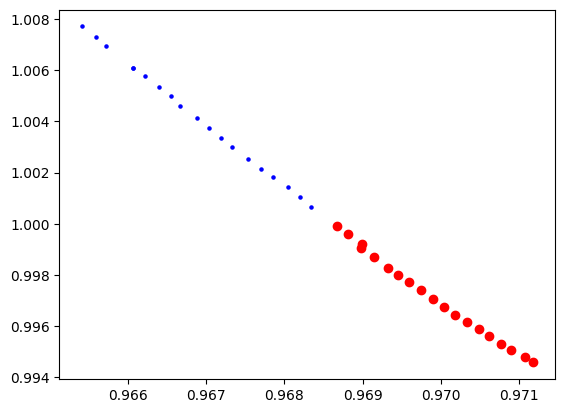

In [19]:
plt.scatter(LSTM_data[0][:,0], LSTM_data[0][:,1], c='r')
plt.scatter(LSTM_label[19][:,0], LSTM_label[19][:,1], c='b', s=5)